<a href="https://colab.research.google.com/github/Joonyoung-Song/DACON-NLP_competition/blob/main/pretrainedEMB_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 23 14:21:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional,GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import word_tokenize
import warnings
import gensim 

import os
warnings.filterwarnings(action='ignore')

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
data_dir = Path('/gdrive/My Drive/dacon_nlp_competition/data')
feature_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/feature')
val_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/val')
tst_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/tst')
sub_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [ ]:
algo_name = 'LSTM'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [ ]:
train = pd.read_csv(trn_file, encoding = 'utf-8',index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [ ]:
test = pd.read_csv(tst_file, encoding = 'utf-8',index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


## Preprocessing

## 불용어 제거

In [ ]:
#알파벳과 숫자를 제외한 나머지 제거
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

#불용어 제거
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num)
# .apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num)
# .apply(remove_stopwords)

In [ ]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879,)


# embedding (GLOVE)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [ ]:
import numpy as np
embedding_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

In [ ]:
embedding_matrix = np.zeros((len(word_index), 100))
embedding_matrix.shape
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    temp = embedding_dict.get(word) # 단어(key) 해당되는 임베딩 벡터의 100개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix[i] = temp 

In [ ]:
embedding_layers=Embedding(len(word_index)+1,
                           100,
                           weights=[embedding_matrix],
                           input_length=max_length,
                           trainable=False)

# embedding (w2v)

In [ ]:
#Word2Vec
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
#Word2Vec
embedding_matrix = np.zeros((len(word_index), 300))
embedding_matrix.shape
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.

## Training

In [ ]:
max_length = 500
vocab_size = 20000
embedding_dim = 64
padding_type='post'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
len(word_index)

47256

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
pd.DataFrame(train_sequences).shape

(54879, 468)

In [ ]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 500) (19617, 500)


In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
import tensorflow as tf
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
def get_model():    
    #  with tf.device('/device:GPU:0'):  
        model = Sequential([
            # Embedding(vocab_size, embedding_dim, input_length=max_length), #self training embedding
            Embedding(47256, 300, weights=[embedding_matrix], input_length=max_length, trainable=False),  #pre-trained embedding(w2v,glove)
            Bidirectional(LSTM(64, return_sequences=True)),
            # Dropout(0.2),
            Bidirectional(LSTM(64)),
            Dense(n_class, activation='softmax')
        ])

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.01))
        return model

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = get_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)
    
    # rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                     patience=3, min_lr=1e-6, mode='min', verbose=1)

    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            callbacks=[es
                      #  ,rlr
                       ]
            )
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
1372/1372 [==============================] - 132s 96ms/step - loss: 1.1743 - val_loss: 1.0147
Epoch 2/10
1372/1372 [==============================] - 136s 99ms/step - loss: 0.8628 - val_loss: 0.8508
Epoch 3/10
1372/1372 [==============================] - 135s 99ms/step - loss: 0.7219 - val_loss: 0.8213
Epoch 4/10
1372/1372 [==============================] - 136s 99ms/step - loss: 0.6275 - val_loss: 0.8112
Epoch 5/10
1372/1372 [==============================] - 136s 99ms/step - loss: 0.5514 - val_loss: 0.8217
Epoch 6/10
1372/1372 [==============================] - 137s 100ms/step - loss: 0.4996 - val_loss: 0.8937
Epoch 00006: early stopping
training model for CV #2
Epoch 1/10
1372/1372 [==============================] - 135s 98ms/step - loss: 1.1397 - val_loss: 0.9295
Epoch 2/10
1155/1372 [========================>.....] - ETA: 19s - loss: 0.8420

KeyboardInterrupt: ignored

In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  74.1413%
Log Loss (CV):   0.7065


In [ ]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  74.2798%
Log Loss (CV):   0.7040


In [ ]:
algo_name = 'lstm'
feature_name = 'emb'
algo_logloss = f'{log_loss(pd.get_dummies(y), p_val):8.4f}'
model_name = f'{algo_name}_{feature_name}_{algo_logloss}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 시각화

In [ ]:
# model summary
print(clf.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 220, 64)           1280000   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 220, 128)          66048     
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 1,445,509
Trainable params: 1,445,509
Non-trainable params: 0
_________________________________________________________________
None


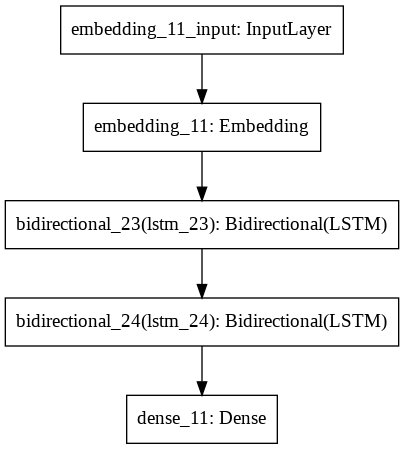

In [ ]:
plot_model(clf)

## 제출 파일 생성


In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [ ]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0235,0.3569,0.5272,0.0765,0.0159
1,0.1718,0.5385,0.0204,0.0188,0.2505
2,0.9837,0.0093,0.0038,0.0006,0.0025
3,0.0137,0.0080,0.8744,0.0043,0.0995
4,0.5738,0.1056,0.0204,0.2629,0.0373


In [ ]:
sub.to_csv(sub_file)